### Setup for data loading

In [6]:
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

In [7]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


### Loading human detection training data

In [8]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [12]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

### Video data loading

In [13]:
# Save corresponding clips
path = 'videos/'
frames = {}
for iClip in bbox:
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        cap.set(1, int(iFrame))
        ret, frame = cap.read()
        if ret:
            frame = torch.from_numpy(frame)
            frames[iClip][iFrame] = frame

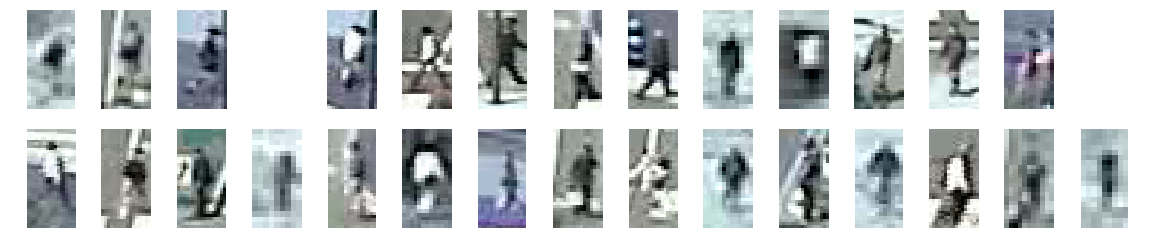

In [14]:
# Random sanity check
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][y:y+h, x:x+w, :])
    except:
        continue

### Training data with still images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 1) crop/zero-padding the image to equal size, or 2) scale the image.

In [15]:
# Generating train data. All images are cropped to (15,30).
# True data
X_sample = torch.zeros(nData,3,15,30)
y_sample = torch.zeros(nData, )
i = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-15)/2)
                y -= int((h-30)/2)
                data = frames[iClip][iFrame][x:x+15, y:y+30,:].to(dtype=torch.float32)
                X_sample[i,:,:,:] = torch.unsqueeze(data.permute(2,0,1),0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [16]:
# False data are randomly sampled from images.
n = X_sample.shape[0]
for i in range(n):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    try:
        data = frames[iClip][iFrame][x:x+15, y:y+30,:].to(dtype=torch.float32)
        X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(2,0,1),0)),0)
        y_sample = torch.cat((y_sample, torch.zeros(1)))
    except:
        continue

In [17]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [28]:
X_train.shape

torch.Size([1772, 3, 15, 30])

In [57]:
# Train CNN
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1, stride=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1, stride=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1, stride=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    Flatten(),
    nn.Linear(16*15*30, 20),
    nn.ReLU(),
    nn.Linear(20, 2),
)
optimizer = optim.Adam(model.parameters(), lr=2.e-4, betas=(0.9, 0.999))

In [58]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    for e in range(epochs):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(X_val,y_val, model)
                print()

In [59]:
train_model(X_train, y_train, model, optimizer, epochs=1)

Iteration 100, loss = 0.7650
Got 172 / 443 correct (38.83)

Iteration 200, loss = 2.8145
Got 274 / 443 correct (61.85)

Iteration 300, loss = 0.8172
Got 279 / 443 correct (62.98)

Iteration 400, loss = 1.0574
Got 280 / 443 correct (63.21)

Iteration 500, loss = 0.6297
Got 287 / 443 correct (64.79)

Iteration 600, loss = 1.2964
Got 276 / 443 correct (62.30)

Iteration 700, loss = 0.6052
Got 283 / 443 correct (63.88)

Iteration 800, loss = 0.3562
Got 278 / 443 correct (62.75)

Iteration 900, loss = 0.5804
Got 288 / 443 correct (65.01)

Iteration 1000, loss = 0.7082
Got 269 / 443 correct (60.72)

Iteration 1100, loss = 0.4825
Got 281 / 443 correct (63.43)

Iteration 1200, loss = 0.5016
Got 280 / 443 correct (63.21)

Iteration 1300, loss = 0.7615
Got 281 / 443 correct (63.43)

Iteration 1400, loss = 1.0013
Got 276 / 443 correct (62.30)

Iteration 1500, loss = 0.9462
Got 281 / 443 correct (63.43)

Iteration 1600, loss = 0.2311
Got 275 / 443 correct (62.08)

Iteration 1700, loss = 0.7144
Got

In [45]:
X_train.unsqueeze(0).shape

torch.Size([1, 1772, 3, 15, 30])